# Probabilistic Regression

When predicting a numerical target, we are accustomed to "settling" for a mere point estimate.  However, it would be preferable to have a (reliable) probability distribution over the range of possible values.  That is the goal of probabilistic regression.

In this lesson we will demonstrate two packages for Probabilistic Regression:

1) **NGBoost** - uses boosting to find the best fitting parameters for a particular distribution (conditional on the feature values).  It is most typically used with the normal distribution (and a decision tree as the base learner).  It uses the so-called "Natural Gradient" to better fit the set of parameters jointly. 
2) **PrestoBoost**  - this algorithm fits multiple gradient boosting forests on sets of intervals and then averages the resulting densities.  As such, it is nonparametric in nature and the resulting conditional distributions may have "interesting" shapes.  It is part of the `structureboost` package, and therefore can also handle categorical structure in its predictors.

References:

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import ngboost as ngb
import structureboost as stb
import ml_insights as mli

import scipy as sp
from sklearn.tree import DecisionTreeRegressor
from joblib import Parallel, delayed
import time
from sklearn.datasets import fetch_openml

## Load / Process Dataset
We will start by analyzing the *Concrete* dataset from the UC-Irvine repository.  The goal is to predict the strength of concrete mixtures based on some attributes about the "recipe" which created it.

In [2]:
# Load in data set and clean up the column names
#df_protein = pd.read_csv("data/CASP.csv")
df_protein = fetch_openml(data_id=42903, as_frame=True, return_X_y=True)[0]

In [3]:
print(df_protein.shape)
df_protein.head()

(45730, 10)


,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102.0,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39.0,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29.0,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70.0,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41.0,39.9147


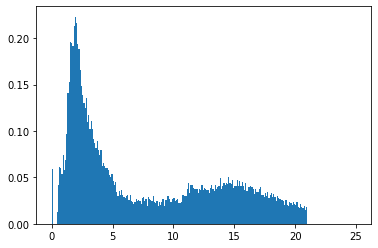

In [4]:
# Here is the marginal probability density 
plt.hist(df_protein.RMSD, bins=np.linspace(0,25,251), density=True);

#### Divide into Training / Validation / Test sets

In [5]:
np.random.seed(999)
foldnum = np.random.randint(0,10,df_protein.shape[0])
pd.Series(foldnum).value_counts()

4    4666
3    4612
2    4595
1    4594
7    4590
6    4582
0    4562
9    4553
8    4490
5    4486
dtype: int64

In [6]:
# 70% train, 10% valid, 20% test
dfc_train = df_protein[foldnum<=3]
dfc_valid = df_protein[(foldnum>3) & (foldnum<=5)]
dfc_test = df_protein[(foldnum>5) & (foldnum<=7)]

dfc_train_val = pd.concat((dfc_train, dfc_valid))

In [7]:
features = df_protein.columns[1:].tolist()
target = 'RMSD'
X_train = dfc_train.loc[:,features]
y_train = dfc_train[target].to_numpy()

X_valid = dfc_valid.loc[:,features]
y_valid = dfc_valid[target].to_numpy()

X_test = dfc_test.loc[:,features]
y_test = dfc_test[target].to_numpy()

X_train_val = dfc_train_val.loc[:,features]
y_train_val = dfc_train_val[target].to_numpy()


### NGBoost
NGBoost works very much like a typical gradient boosting package.  Under the hood, it is trying to optimize the parameters of the specified distribution for the target variable.  By default, this is the normal distribution, so it uses gradient boosting to fit the mean and variance.  It uses the "natural gradient" which allows it to fit the pair of values more effectively by handling the scaling more efficiently.

In [8]:
ngb1 = ngb.NGBRegressor(n_estimators=500, learning_rate=.05)
ngb1.fit(X_train, y_train)

[iter 0] loss=3.2277 val_loss=0.0000 scale=1.0000 norm=5.5027
[iter 100] loss=2.8625 val_loss=0.0000 scale=1.0000 norm=3.8142
[iter 200] loss=2.7783 val_loss=0.0000 scale=2.0000 norm=7.1749
[iter 300] loss=2.7175 val_loss=0.0000 scale=0.5000 norm=1.7208
[iter 400] loss=2.6814 val_loss=0.0000 scale=0.2500 norm=0.8387


NGBRegressor(learning_rate=0.05,
             random_state=RandomState(MT19937) at 0x114E2A440)

In [9]:
# Generally, when you use probabilistic regression you want to get a distribution for each prediction
distr_preds_ngb = ngb1.pred_dist(X_test)

In [10]:
# Let's look inside - we have a "location" and "scale" parameter for each test point
# These are the predicted mean and variance of the normal distribution
distr_preds_ngb.loc[:10], distr_preds_ngb.scale[:10]

(array([ 8.30983762,  5.10983913, 12.25110427,  9.77302434, 10.87189826,
         3.88516608,  6.73666185, 10.41840641,  3.3249778 , 10.92858535]),
 array([4.35059182, 3.17197988, 6.07412876, 5.34135284, 4.77520165,
        2.90610123, 3.99739333, 4.43356941, 2.16149128, 4.72495108]))

In [11]:
## To get a point prediction, you can just use `predict`
point_preds_ngb = ngb1.predict(X_test)

In [12]:
# Just gives the mean of the distribution (location)
point_preds_ngb[:10]

array([ 8.30983762,  5.10983913, 12.25110427,  9.77302434, 10.87189826,
        3.88516608,  6.73666185, 10.41840641,  3.3249778 , 10.92858535])

## Evaluating Distributional Predictions
The most common way to evaluate the quality of distributional prediction is the "log-loss", aka the (average) negative log-likelihood of the test data given the predicted distributions.

Essentially, for each test point, you find the predicted probability density at that point, take the log, negate it (to make a loss function) and average across all test points.

In [13]:
# Get the logs of the predicted densities
logpdf_vals_test= distr_preds_ngb.logpdf(y_test)

In [14]:
# Calculate the log_loss
ngb1_log_loss_test = -distr_preds_ngb.logpdf(y_test).mean()
ngb1_log_loss_test

2.9336870362025547

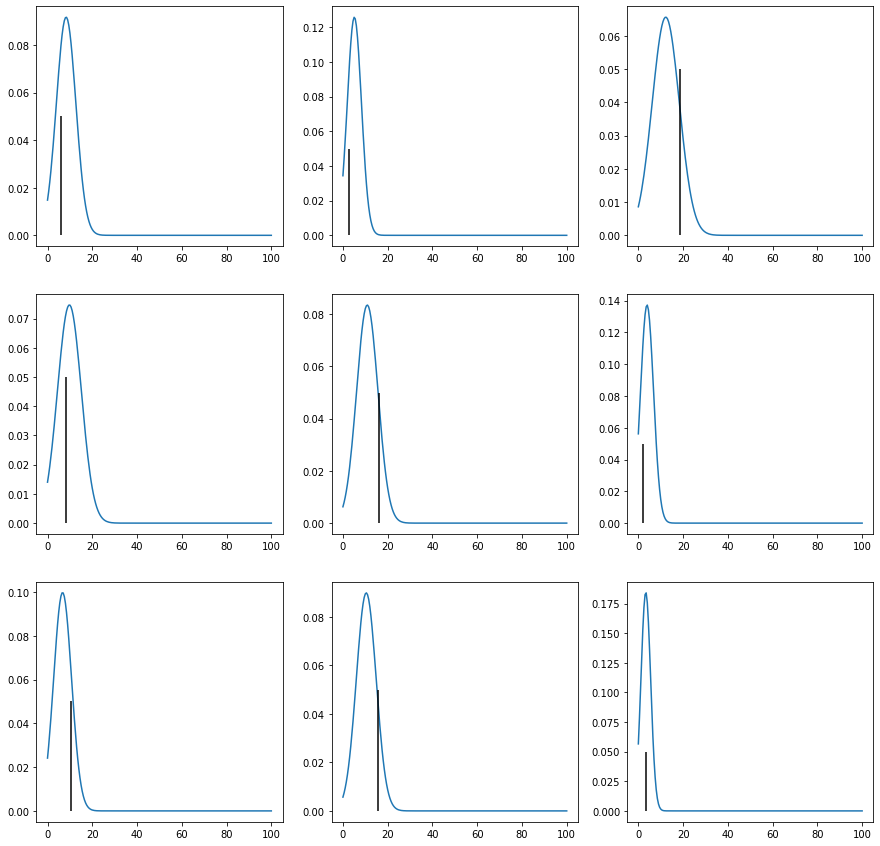

In [15]:
## Plot the distribution for a particular point (and the actual value)
plt.figure(figsize=(15,15))
for index in range(9):
    plt.subplot(3,3,index+1)
    xpts = np.linspace(0,100,201)
    plt.plot(xpts, [sp.stats.norm(distr_preds_ngb.params['loc'][index],distr_preds_ngb.params['scale'][index]).pdf(x) for x in xpts ]);
    plt.vlines(y_test[index], ymin=0, ymax=.05, color='black');

## Prediction Intervals
Another valuable aspect of having a predicted density, is that you can generate confidence intervals.  The simplest way to do this is to look at the quantiles of the predicted distribution.

In [16]:
# Create lists of prediction intervals for the test set (95% and 80%) 
ci95_ngb_test = [sp.stats.norm(distr_preds_ngb.params['loc'][i],
              distr_preds_ngb.params['scale'][i]).interval(.95) for i in range(X_test.shape[0])]

ci80_ngb_test = [sp.stats.norm(distr_preds_ngb.params['loc'][i],
              distr_preds_ngb.params['scale'][i]).interval(.80) for i in range(X_test.shape[0])]

In [17]:
# check each point to see if it is in the interval or not
in_interval_95 = [(y_test[i]>=ci95_ngb_test[i][0]) & 
                 (y_test[i]<=ci95_ngb_test[i][1]) for i in range(X_test.shape[0])]
in_interval_80 = [(y_test[i]>=ci80_ngb_test[i][0]) & 
                 (y_test[i]<=ci80_ngb_test[i][1]) for i in range(X_test.shape[0])]

In [18]:
## Check the coverages
np.mean(in_interval_95), np.mean(in_interval_80)

(0.9376362843436546, 0.7873964238988225)

The prediction intervals are doing reasonably well, but falling short of the promised coverage

## Optimizing the model
Let's optimize the max-depth and number of trees using the validation set.  NGBoost is written generically to take any base estimator- so to change the max-depth you have to do it within the `Base` object.

In [19]:
md_list = []
best_num_trees_list = []
best_ll_val_list = []
for md in range(3,17):
    print(f'max_depth={md}')
    md_list.append(md)
    ngb_tmp = ngb.NGBRegressor(n_estimators=350, learning_rate=.05, 
                               Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=md)
                                )
    ngb_tmp.fit(X_train, y_train)
    
    # "Staged" prediction tries each number of trees within the forest 
    y_forecasts = ngb_tmp.staged_pred_dist(X_valid.to_numpy())
    
    # Get the log_loss for each number of trees in the forest
    val_nll = [-y_forecast.logpdf(y_valid.flatten()).mean() for y_forecast in y_forecasts]
    best_itr = np.argmin(val_nll) + 1
    best_ll_val = np.min(val_nll)
    forecast_val = ngb1.pred_dist(X_valid, max_iter=best_itr)
    best_num_trees_list.append(best_itr)
    best_ll_val_list.append(best_ll_val)
    print(f'for max-depth {md} \n the best log-loss on valid set was {best_ll_val} \n using {best_itr+1} trees')

max_depth=3
[iter 0] loss=3.2277 val_loss=0.0000 scale=1.0000 norm=5.5027
[iter 100] loss=2.8625 val_loss=0.0000 scale=1.0000 norm=3.8142
[iter 200] loss=2.7783 val_loss=0.0000 scale=2.0000 norm=7.1749
[iter 300] loss=2.7175 val_loss=0.0000 scale=0.5000 norm=1.7208
for max-depth 3 
 the best log-loss on valid set was 2.8734994636862647 
 using 292 trees
max_depth=4
[iter 0] loss=3.2277 val_loss=0.0000 scale=1.0000 norm=5.5027
[iter 100] loss=2.7281 val_loss=0.0000 scale=2.0000 norm=6.9740
[iter 200] loss=2.6212 val_loss=0.0000 scale=1.0000 norm=3.2428
[iter 300] loss=2.5692 val_loss=0.0000 scale=1.0000 norm=3.1197
for max-depth 4 
 the best log-loss on valid set was 2.875199712096847 
 using 126 trees
max_depth=5
[iter 0] loss=3.2277 val_loss=0.0000 scale=1.0000 norm=5.5027
[iter 100] loss=2.6106 val_loss=0.0000 scale=1.0000 norm=3.1926
[iter 200] loss=2.4752 val_loss=0.0000 scale=1.0000 norm=2.9281
[iter 300] loss=2.3974 val_loss=0.0000 scale=1.0000 norm=2.7764
for max-depth 5 
 the b

In [20]:
best_ind = np.argmin(best_ll_val_list)
md_to_use = md_list[best_ind]
num_trees_to_use = best_num_trees_list[best_ind]
md_to_use, num_trees_to_use

(10, 28)

In [21]:
ngb_opt =  ngb.NGBRegressor(n_estimators=num_trees_to_use, learning_rate=.05, 
                               Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=md_to_use)
                                )
ngb_opt.fit(X_train, y_train)


[iter 0] loss=3.2277 val_loss=0.0000 scale=1.0000 norm=5.5027


NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=10),
             learning_rate=0.05, n_estimators=28,
             random_state=RandomState(MT19937) at 0x114E2A440)

In [22]:
pred_dists_ngb_opt = ngb_opt.pred_dist(X_test)

In [23]:
-pred_dists_ngb_opt.logpdf(y_test).mean()

2.7703225213703186

In [24]:
# Create lists of prediction intervals for the test set (95% and 80%) 
ci95_ngb_test_opt = [sp.stats.norm(pred_dists_ngb_opt.params['loc'][i],
              distr_preds_ngb.params['scale'][i]).interval(.95) for i in range(X_test.shape[0])]

ci80_ngb_test_opt = [sp.stats.norm(pred_dists_ngb_opt.params['loc'][i],
              distr_preds_ngb.params['scale'][i]).interval(.80) for i in range(X_test.shape[0])]

In [25]:
# check each point to see if it is in the interval or not
in_interval_95_opt = [(y_test[i]>=ci95_ngb_test_opt[i][0]) & 
                 (y_test[i]<=ci95_ngb_test_opt[i][1]) for i in range(X_test.shape[0])]
in_interval_80_opt = [(y_test[i]>=ci80_ngb_test_opt[i][0]) & 
                 (y_test[i]<=ci80_ngb_test_opt[i][1]) for i in range(X_test.shape[0])]

In [26]:
## Check the coverages
np.mean(in_interval_95_opt), np.mean(in_interval_80_opt)

(0.9379633667684256, 0.8217400784997819)

Still not getting the promised coverage for 95%, though we are close for the 80% interval

## PrestoBoost
PrestoBoost works by fitting multiple gradient boosting forests to coarsely classify the target into intervals.  The classifier assigns a particular probability to each interval, which can then be converted into a probability density.  Each forest uses a different set of intervals and the resulting densities are averages.  As such, it is a nonparametric methods and makes no assumptions about the form of the distribution (other than a minimum/maximum value). 

StructureBoost is a gradient boosting package that allows the user to incorporate known *structure* of categorical variables so that it can be exploited by the model.  Recently, PrestoBoost was added to the package.  PrestoBoost incorporates some of the structural capabilities of StructureBoost.


In [27]:
# StructureBoost allows configuration at the feature level - so it requires a more sophisticated configuration
# The following command gives a reasonable set of defaults based on the training data.
fc = stb.get_basic_config(X_train, stb.default_config_dict())
fc

{'F1': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'F2': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'F3': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'F4': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'F5': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'F6': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'F7': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'F8': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'F9': {'feature_type': 'numerical', 'max_splits_to_search': 25}}

In [28]:
stb1 = stb.PrestoBoost(num_forests = 8, num_trees = 100, 
                       learning_rate=.07, feature_configs= fc, binpt_sample_size=25, max_depth=10)
start_time = time.time()
stb1.fit(X_train, y_train)
end_time = time.time()
end_time-start_time

Training Forest 0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 1
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 2
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 3
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 4
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 5
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 6
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 7
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90


1194.1284127235413

In [29]:
test_dists_conc = stb1.predict_distributions(X_test)

In [30]:
test_dists_conc.log_loss(y_test)

1.7004110336041407

In [31]:
stb.log_loss_pdf(y_test, test_dists_conc)

1.7004110336041407

In [32]:
# We'll use parallelization to speed up the training
stb2 = stb.PrestoBoost(num_forests = 7, num_trees = 50, feature_configs= fc, binpt_sample_size=25, max_depth=5)
start_time = time.time()
stb2.fit(X_train, y_train, eval_set = (X_valid, y_valid), early_stop_past_steps=2, n_jobs=-1)
end_time = time.time()

Training Forests


In [33]:
end_time-start_time

33.267151832580566

In [34]:
pred_dists_stb = stb2.predict_distributions(X_test)

In [35]:
pred_dists_stb.log_loss(y_test)

2.29784643187467

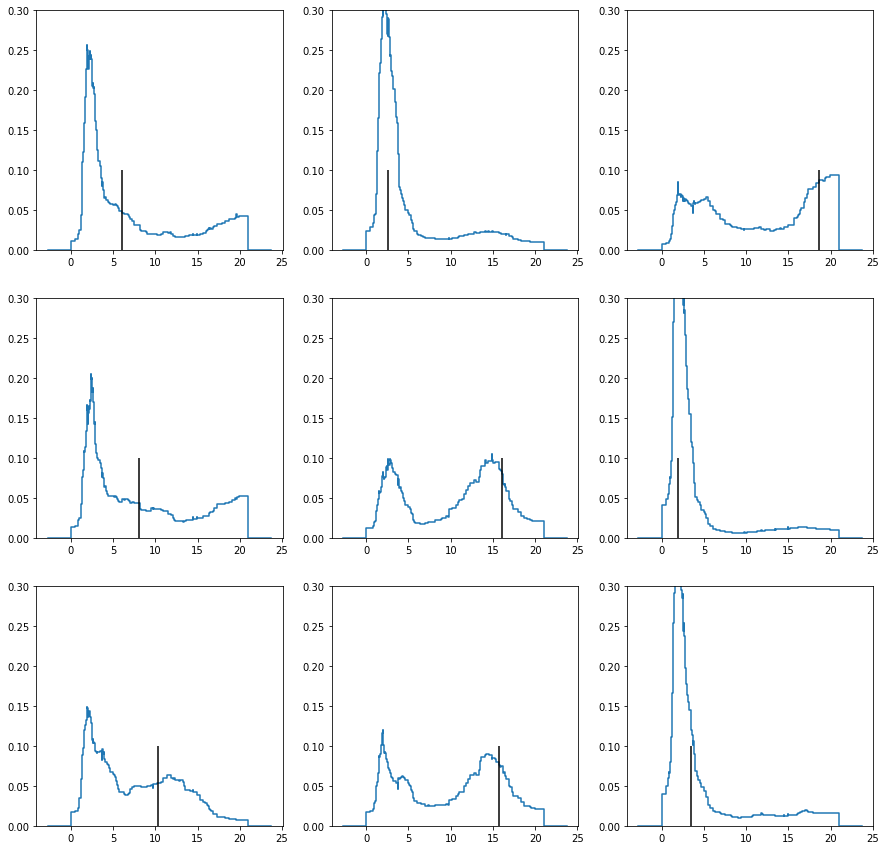

In [36]:
# These are the predicted distributions of the first 9 points of the test set
# Notice the variety of shapes
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    pred_dists_stb[i].plot_density()
    plt.ylim([0,.3])
    plt.vlines(y_test[i], ymin=0, ymax=.1, color='black')

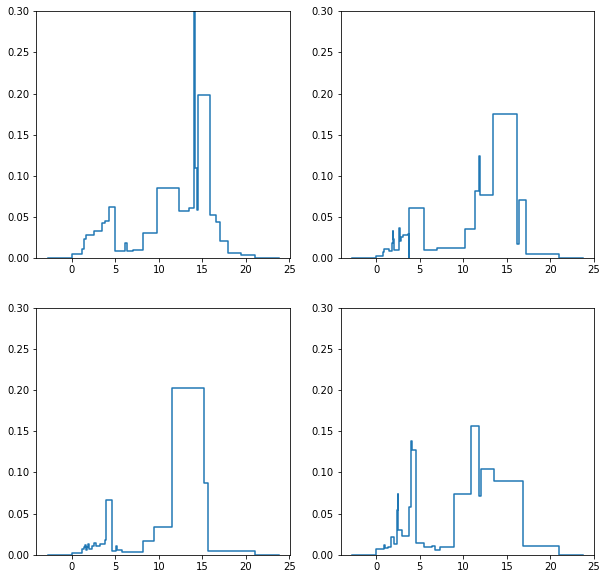

In [37]:
# Let's analyze the center distribution from the above plot
# Below are the predictions from 4 different coarse classifiers
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    stb1.forest_list[i].predict_distributions(X_test[:10])[4].plot_density()    
    plt.ylim([0,.3])

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_42690/3297412152.py:4: UserWarning: Using only the 8 that are available
  tmp_test = stb1.predict_distributions(X_test[:20], num_forests_to_use=nf)


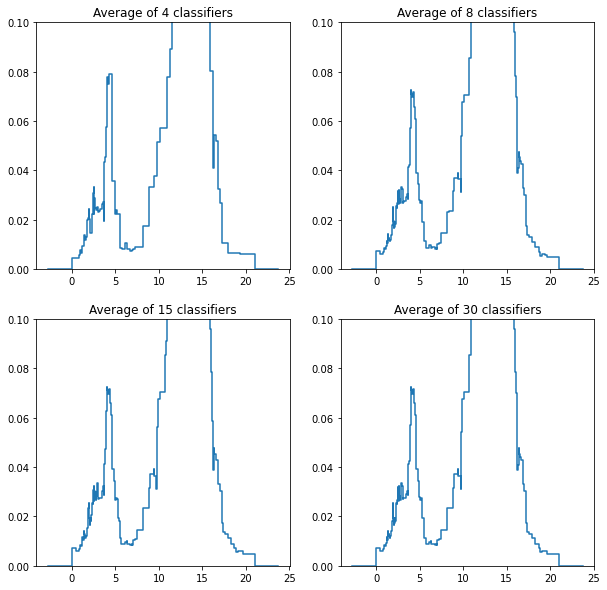

In [38]:
plt.figure(figsize=(5,10))
for i,nf in enumerate([4,8]):
    plt.subplot(2,2,i+1)
    tmp_test = stb1.predict_distributions(X_test[:20], num_forests_to_use=nf)
    tmp_test[4].plot_density()
    plt.ylim([0,.5])
    plt.title('Average of '+str(nf)+' classifiers')

## Let's optimize the model
PrestoBoost makes it simple to use a validation set for early stopping, and then retrain on the combined training and validation sets.

In [39]:
stb3 = stb.PrestoBoost(num_forests = 15, num_trees = 500, feature_configs= fc, bin_interp='runif',
                         learning_rate=0.07, binpt_sample_size=25, max_depth=10)
start_time=time.time()
stb3.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps = 2, n_jobs=-1)
end_time=time.time()

Training Forests


In [40]:
end_time-start_time

1738.8291327953339

In [41]:
pred_dists_test_stb_opt = stb3.predict_distributions(X_test)

In [42]:
pred_dists_test_stb_opt.log_loss(y_test)

1.6494165145640034

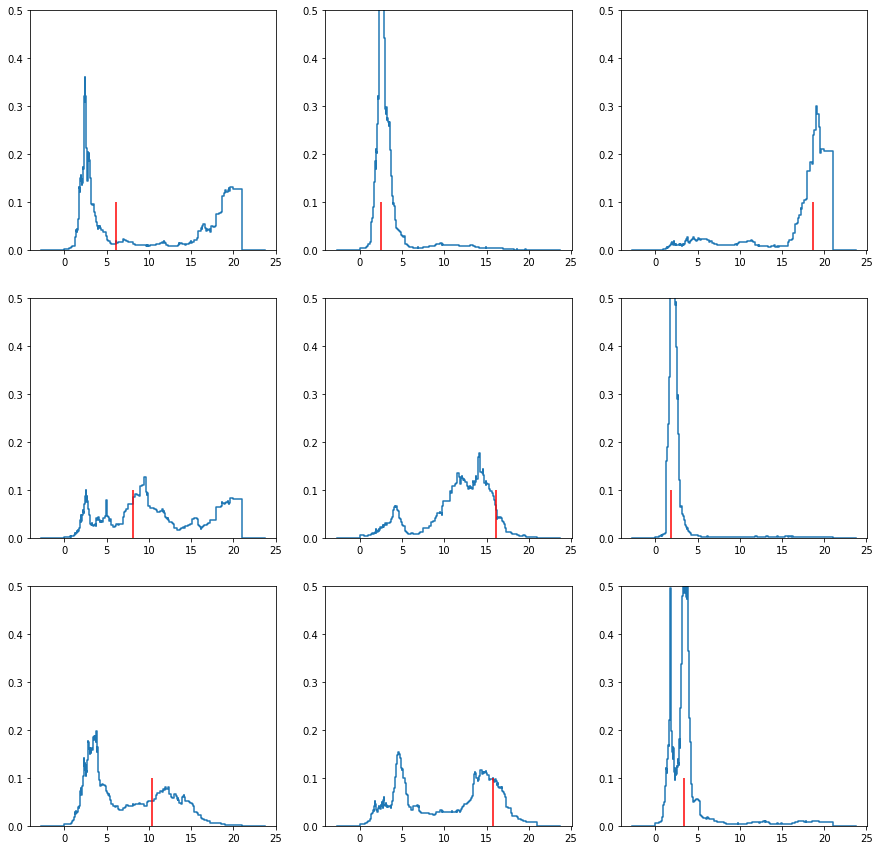

In [43]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    pred_dists_test_stb_opt[i].plot_density()
    plt.ylim([0,.5])
    plt.vlines(y_test[i], ymin=0, ymax=.1, color='red')

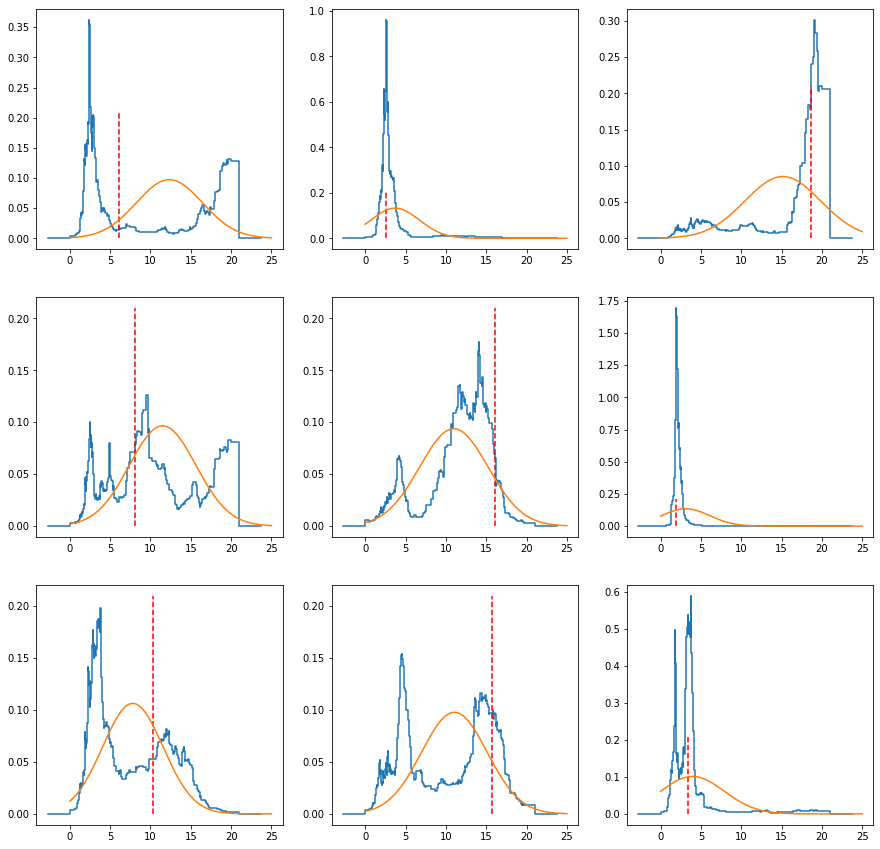

In [44]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    pred_dists_test_stb_opt[i].plot_density()
    plt.vlines(y_test[i], ymin=0, ymax=.21, color='red', linestyle='--')    
    xpts = np.linspace(0,25,201)
    plt.plot(xpts, [sp.stats.norm(pred_dists_ngb_opt.params['loc'][i],pred_dists_ngb_opt.params['scale'][i]).pdf(x) for x in xpts ]);


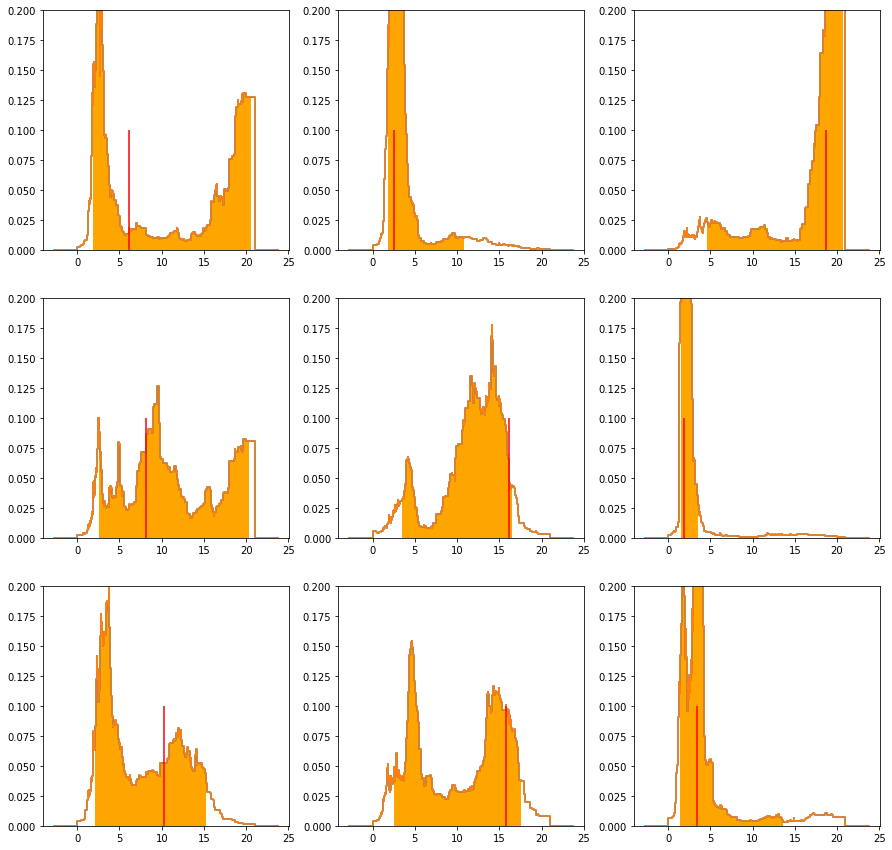

In [45]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    pred_dists_test_stb_opt[i].plot_density(pred_alpha=.8, pred_type='interval')
    plt.ylim([0,.2])
    plt.vlines(y_test[i], ymin=0, ymax=.1, color='red')

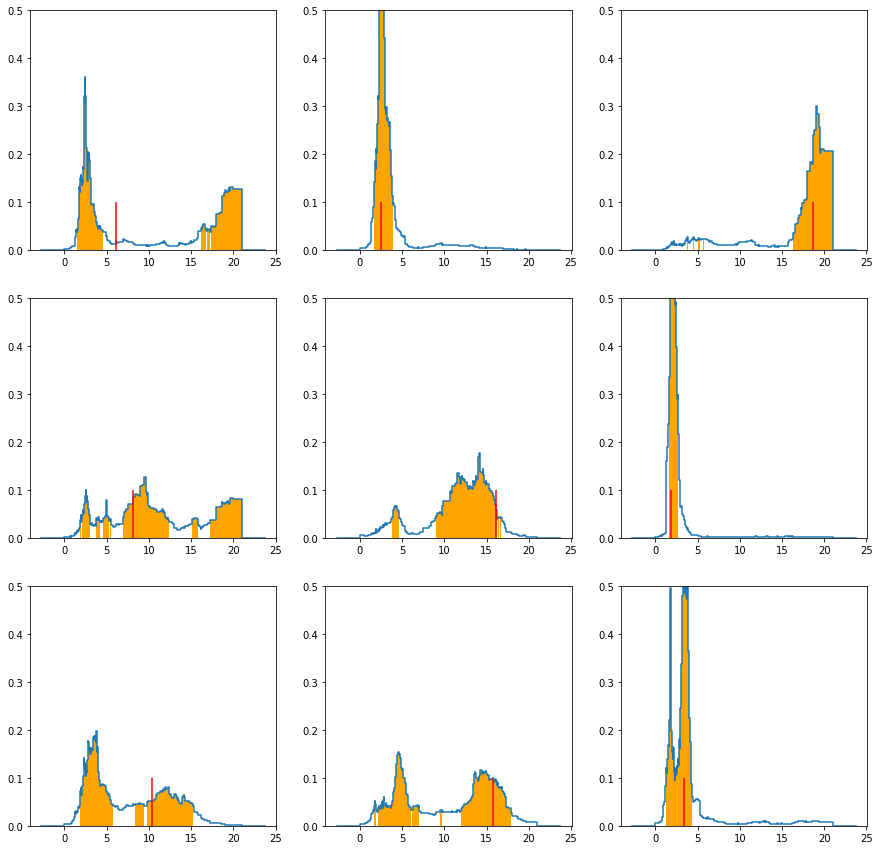

In [46]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    pred_dists_test_stb_opt[i].plot_density(pred_alpha=.8, pred_type='region')
    plt.ylim([0,.5])
    plt.vlines(y_test[i], ymin=0, ymax=.1, color='red')

In [47]:
pred_dists_test_stb_opt.test_between_quantiles(y_test, .025, .975).mean()

0.9729611862189271

In [48]:
pred_dists_test_stb_opt.test_between_quantiles(y_test, .1, .9).mean()

0.8784343654600959

In [49]:
pred_dists_test_stb_opt.test_in_pred_regions(y_test,.95).mean()

0.969581334496293

In [50]:
pred_dists_test_stb_opt.test_in_pred_regions(y_test,.80).mean()

0.8648059310946359